# Modelo de Fatores Dinâmicos (DFM) - 5 fatores: PCA + OLS estimation
---

> Modelo inicial, análise de resíduos, de sazonalidade, resultados iniciais e expansão do modelo com defasagens.

## Bibliotecas

In [667]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan

# Dados

In [668]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

data_pca = data_pca[['F1', 'F2', 'F3', 'F4', 'F5']]

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC')
new_data

C:\Users\HENRI\AppData\Local\Temp\ipykernel_9568\4076545688.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
2002-03-01,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411,0.437357,3.542712,-1.410008,1.441429,0.024750,1.164838
2002-06-01,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521,0.555046,2.055331,-1.683349,2.263962,-1.414056,1.427494
2002-09-01,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402,1.708108,2.452098,0.985706,2.723189,-2.060487,1.139600
2002-12-01,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546,1.241341,2.347363,-0.177495,3.033051,-1.434443,0.645385
2003-03-01,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151,0.577081,4.299099,-1.396467,0.792031,0.023317,1.337094
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580,-0.136194,-1.399026,1.282804,-0.357813,0.517160,-0.088135
2021-12-01,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121,-0.989648,-1.303261,1.347845,1.466352,1.267444,-0.986221
2022-03-01,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385,1.439377,-0.281474,0.233960,-3.768976,2.572942,0.308770
2022-06-01,1.786737,-0.366600,-0.601419,0.377088,-1.336048,-1.747521,-0.829394,0.277045,2.288487,-4.953368,-2.686125,1.381419


In [669]:
# Criando defasagens dos fatores

# Lags Fator 1
new_data['F1_1'] = new_data['F1'].shift(1)
new_data['F1_2'] = new_data['F1'].shift(2)
new_data['F1_3'] = new_data['F1'].shift(3)
new_data['F1_4'] = new_data['F1'].shift(4)
new_data['F1_6'] = new_data['F1'].shift(6)


# Lags Fator 2
new_data['F2_1'] = new_data['F2'].shift(1)
new_data['F2_2'] = new_data['F2'].shift(2)
new_data['F2_3'] = new_data['F2'].shift(3)
new_data['F2_4'] = new_data['F2'].shift(4)

# Lags Fator 3
new_data['F3_1'] = new_data['F3'].shift(1)
new_data['F3_2'] = new_data['F3'].shift(2)
new_data['F3_3'] = new_data['F3'].shift(3)
new_data['F3_4'] = new_data['F3'].shift(4)

# Lags Fator 4
new_data['F4_1'] = new_data['F4'].shift(1)
new_data['F4_2'] = new_data['F4'].shift(2)
new_data['F4_3'] = new_data['F4'].shift(3)
new_data['F4_4'] = new_data['F4'].shift(4)
new_data['F4_6'] = new_data['F4'].shift(6)

# Lags fator 5
new_data['F5_1'] = new_data['F5'].shift(1)
new_data['F5_2'] = new_data['F5'].shift(2)
new_data['F5_3'] = new_data['F5'].shift(3)
new_data['F5_4'] = new_data['F5'].shift(4)

# Lags GDP
new_data['gdp_1'] = new_data['gdp'].shift(1)
new_data['gdp_2'] = new_data['gdp'].shift(2)
new_data['gdp_3'] = new_data['gdp'].shift(3)
new_data['gdp_4'] = new_data['gdp'].shift(4)

In [670]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

# Modelo
---

## Regressões

In [671]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = train)
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     16.25
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           5.38e-10
Time:                        16:40:44   Log-Likelihood:                -129.41
No. Observations:                  64   AIC:                             270.8
Df Residuals:                      58   BIC:                             283.8
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5255      0.248      2.115      0.0

In [672]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit()
pred = dfm_5fac.predict(test.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit()
    pred = dfm_5fac.predict(test.loc[j]).values[0]
    list_5fac.append(pred)

list_5fac

[-0.46919795405136316,
 2.74864684895456,
 0.5989023312090751,
 -1.8483330821643182,
 -1.977878965583903,
 2.2482716178087596,
 2.8689281558475916,
 -2.6354647692750093,
 -0.5278429573915773,
 0.24228208651476912,
 1.3959859191820165,
 -0.5179942431580921,
 -0.05812409476262381,
 0.5341087383939507,
 0.4144508154150295,
 0.3831980308614621,
 -1.3313868614543125,
 0.8305971406778356,
 1.7858433084479726]

## Perfomance

### Previsões

<AxesSubplot: >

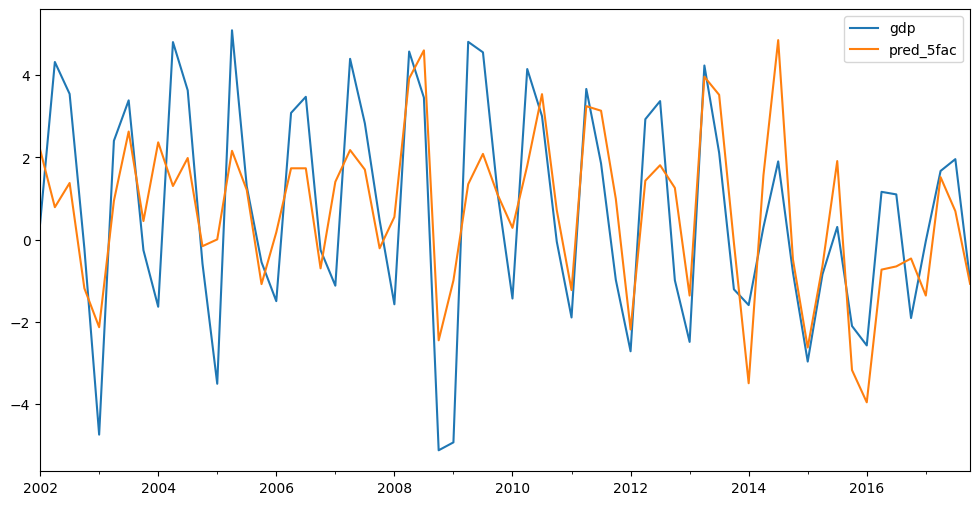

In [673]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train
forecasts_insample['pred_5fac'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

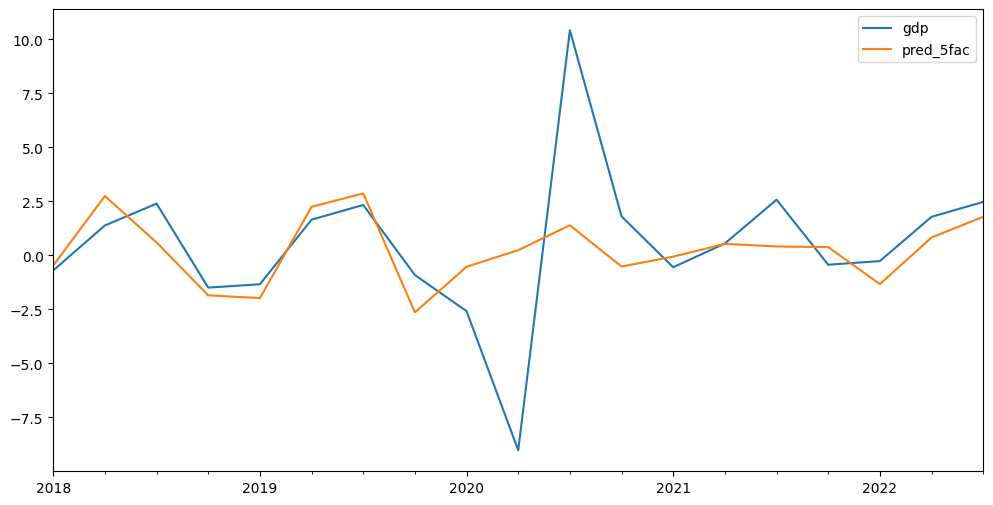

In [674]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_5fac'] = list_5fac
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD e MAPE

In [675]:
# Métricas IN-SAMPLE

rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac'])
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac'])
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

1.827842929311588

1.5208702710661632

1.8030293659950782


In [676]:
# Métricas OUT-OF-SAMPLE

rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

3.1977164484578124

1.9005002265647193

0.9355200793639435


# Análise dos resíduos

## Autocorrelação

In [677]:
# Criando função para plotar as autocorrelações dos resíduos das regressões

def autocorr_plots(y1, y2, title1, title2):
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(211) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a primeira posição
    fig = plot_acf(y1, ax = ax1, title = title1)
    ax2 = fig.add_subplot(212) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a segunda posição
    fig = plot_acf(y2, ax=ax2, title = title2)

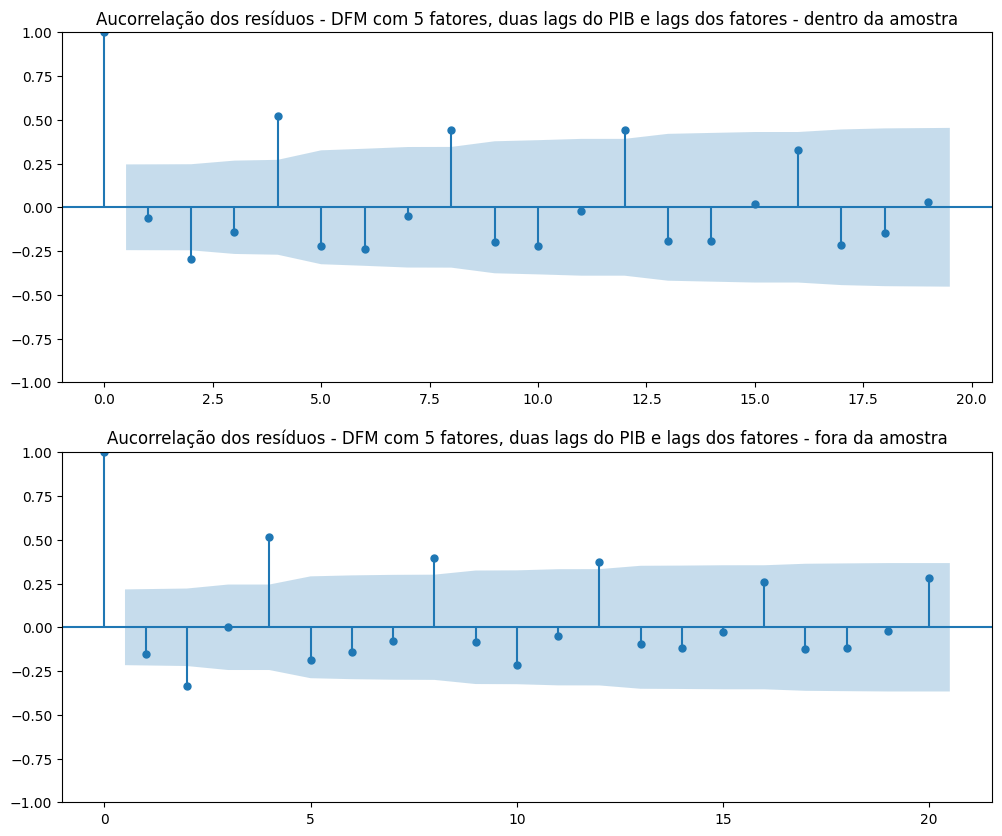

In [679]:
# Plotando a função de autocorrelação

autocorr_plots(dfm.resid, dfm_5fac.resid,
               'Autocorrelação dos resíduos - DFM com 5 fatores, duas lags do PIB e lags dos fatores - dentro da amostra',
               'Autocorrelação dos resíduos - DFM com 5 fatores, duas lags do PIB e lags dos fatores - fora da amostra')

In [681]:
# Teste de Breusch-Godfray para autocorrelação dos erros - IN-SAMPLE

bg_result = acorr_breusch_godfrey(dfm, nlags = 12)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm.resid, lags = 12)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.0

   lb_stat  lb_pvalue
1   0.2629     0.6082
2   6.2955     0.0429
3   7.6886     0.0529
4  26.6840     0.0000
5  30.2354     0.0000
6  34.3271     0.0000
7  34.5249     0.0000
8  49.1534     0.0000


In [682]:
# Teste de Breusch-Godfray para autocorrelação dos erros - OUT-OF-SAMPLE 

bg_result = acorr_breusch_godfrey(dfm_5fac, nlags = 8)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm_5fac.resid, lags = 8)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.0

   lb_stat  lb_pvalue
1   1.9929     0.1580
2  11.7377     0.0028
3  11.7380     0.0083
4  35.3357     0.0000
5  38.4716     0.0000
6  40.2294     0.0000
7  40.8176     0.0000
8  55.5097     0.0000


## Heteroscedasticidade

In [683]:
# IN-SAMPLE

het_breuschpagan(dfm.resid.loc['2003Q3':'2017Q4',], X_train.loc['2003Q3':'2017Q4',])

(53.36437698517746,
 0.03122659875086942,
 6.533725789044845,
 1.3749837987399212e-05)

In [684]:
# OUT-SAMPLE

het_breuschpagan(dfm_5fac.resid.loc['2003Q3':'2022Q2',], new_data.loc['2003Q3':'2022Q2',])

(64.80246608957171,
 0.0031480531006975003,
 5.787208737918714,
 1.8671544443284854e-07)

## Distribuição e comportamento no tempo

<AxesSubplot: xlabel='date', ylabel='resid'>

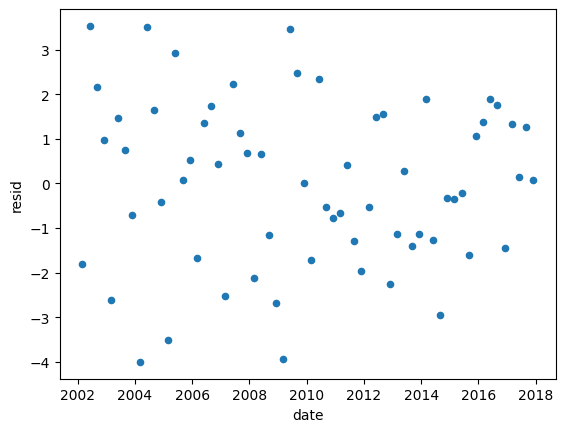

In [685]:
# Modelo com dados apenas dentro da amostra

resids_plot = pd.DataFrame({'date':dfm.resid.index, 'resid':dfm.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

<AxesSubplot: xlabel='date', ylabel='resid'>

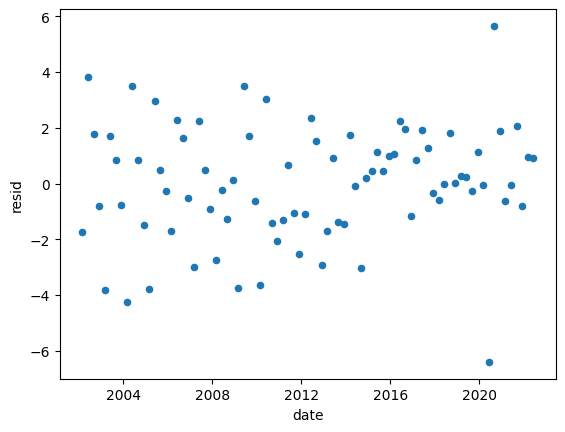

In [686]:
# Out-of-sample

resids_plot = pd.DataFrame({'date':dfm_5fac.resid.index, 'resid':dfm_5fac.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

# Modelo: adicionando a dinâmica

## Regressões

In [687]:
'''reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 +'
              'F5', 
              data = new_data)
              
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())'''

"reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'\n              'F1 + F1_4 +'\n              'F2 + F2_2 +'\n              'F3 + F3_1 + F3_2 + F3_3 +'\n              'F4 +'\n              'F5', \n              data = new_data)\n              \ndfm = reg.fit(cov_type = 'HC1')\nprint(dfm.summary())"

In [688]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 +'
              'F5', 
              data = train)
train['e_1'] = dfm.resid.shift(1)

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 +'
              'F5 +'
              'e_1', 
              data = train)
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     91.60
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           2.37e-28
Time:                        16:40:47   Log-Likelihood:                -64.114
No. Observations:                  60   AIC:                             156.2
Df Residuals:                      46   BIC:                             185.5
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5659      0.148      3.824      0.0

C:\Users\HENRI\AppData\Local\Temp\ipykernel_9568\3050251752.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['e_1'] = dfm.resid.shift(1)


In [689]:
'''# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + F4_1 + '
              'F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit(cov_type = 'HC1')
pred = dfm_5fac.predict(test.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + F4_1 + '
              'F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit(cov_type = 'HC1')
    pred = dfm_5fac.predict(test.loc[j]).values[0]
    list_5fac.append(pred)

list_5fac'''

"# Modelo calibrado para prever resultados fora da amostra\n\n# test_1fac = test[['F1']].copy()\nlist_5fac = list()\n\nreg = smf.ols('gdp ~ gdp_2 + gdp_4 +'\n              'F1 + F1_4 +'\n              'F2 + F2_2 +'\n              'F3 + F3_1 + F3_2 + F3_3 +'\n              'F4 + F4_1 + '\n              'F5', data = new_data.loc['2002Q1':'2017Q4',])\ndfm_5fac = reg.fit(cov_type = 'HC1')\npred = dfm_5fac.predict(test.loc['2018Q1']).values[0]\nlist_5fac.append(pred)\n\nfor i, j in zip(test.index, new_data.loc['2018Q2':,].index):\n    reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'\n              'F1 + F1_4 +'\n              'F2 + F2_2 +'\n              'F3 + F3_1 + F3_2 + F3_3 +'\n              'F4 + F4_1 + '\n              'F5', data = new_data.loc['2002Q1':i,])\n    dfm_5fac = reg.fit(cov_type = 'HC1')\n    pred = dfm_5fac.predict(test.loc[j]).values[0]\n    list_5fac.append(pred)\n\nlist_5fac"

In [690]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit(cov_type = 'HC1')
pred = dfm_5fac.predict(new_data.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(new_data.loc['2018Q1':,].index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit(cov_type = 'HC1')
    pred = dfm_5fac.predict(new_data.loc[j]).values[0]
    list_5fac.append(pred)

new_data['e_1'] = dfm_5fac.resid.shift(1)

list_5fac = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5 +'
              'e_1', 
              data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit(cov_type = 'HC1')
pred = dfm_5fac.predict(new_data.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(new_data.loc['2018Q1':,].index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5 +'
              'e_1', 
              data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit(cov_type = 'HC1')
    pred = dfm_5fac.predict(new_data.loc[j]).values[0]
    list_5fac.append(pred)
list_5fac

[-0.3954803928632121,
 2.1786148154882214,
 2.4136706522044724,
 -1.5060967348551466,
 -1.3902809128124125,
 1.186469930603977,
 1.5936332734987793,
 -0.861222601275583,
 -3.0822277276940917,
 -7.122175794269903,
 9.621697034973232,
 1.3866553227545984,
 -3.9396114229158554,
 -1.5464047739305125,
 2.1277099310669123,
 -0.02738419012868268,
 -1.3869060825854245,
 0.10108256435797947,
 nan]

In [691]:
print(dfm_5fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     132.9
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           1.38e-40
Time:                        16:40:48   Log-Likelihood:                -78.982
No. Observations:                  77   AIC:                             186.0
Df Residuals:                      63   BIC:                             218.8
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7402      0.103      7.154      0.0

## Inserindo os resíduos nos dados de treino e teste

In [692]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

## Performance

### Previsões

<AxesSubplot: >

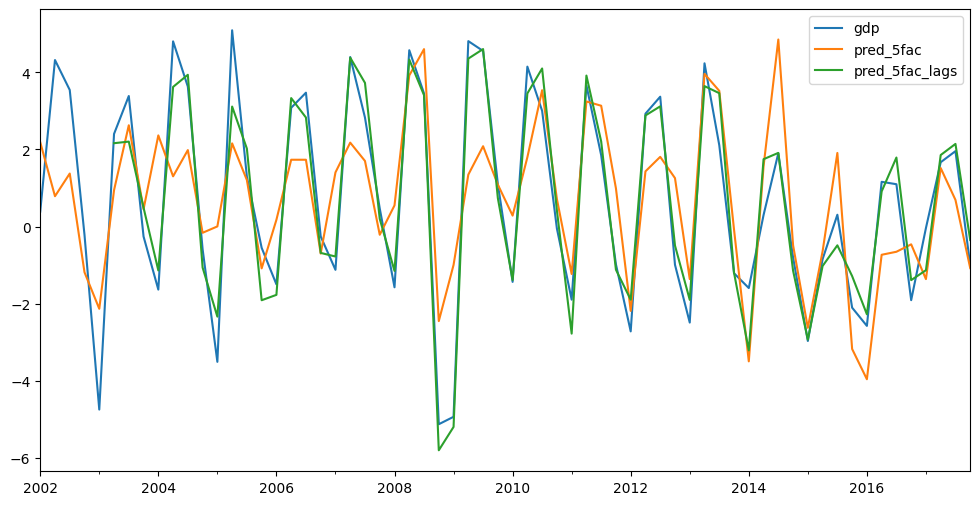

In [693]:
# Previsões IN-SAMPLE

forecasts_insample['pred_5fac_lags'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

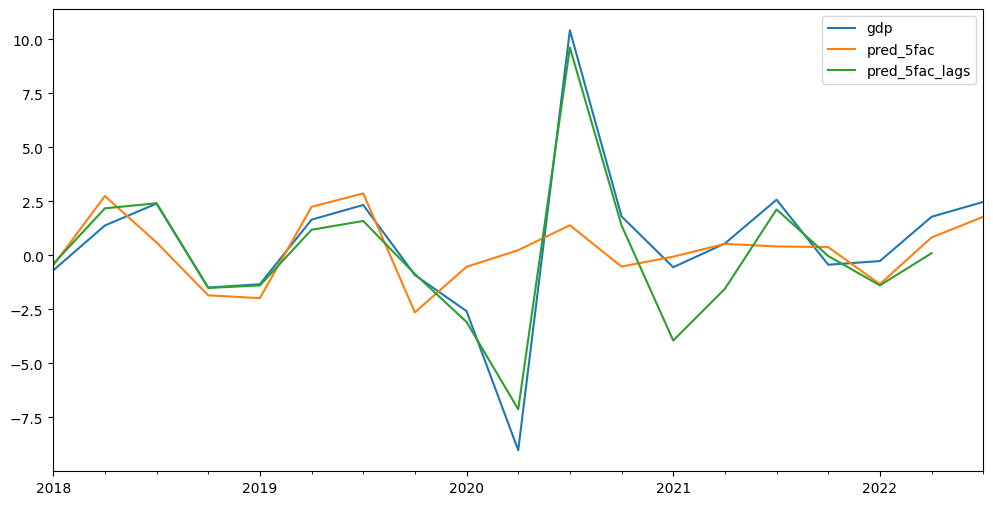

In [694]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample['pred_5fac_lags'] = list_5fac
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD, MAPE

In [695]:
# Métricas IN-SAMPLE

forecasts_insample = forecasts_insample.dropna(axis = 0)
rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac_lags']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac_lags'].dropna())
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac_lags'].dropna())
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

0.7091522623138881

0.5550687786870927

1.1354113192265807


In [696]:
# Métricas OUT-OF-SAMPLE

forecasts_outsample = forecasts_outsample.dropna(axis = 0)
rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac_lags']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac_lags'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac_lags'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

1.2142020785626981

0.8449980958261655

1.0418322117986747


# Análise dos resíduos

## Autocorrelação

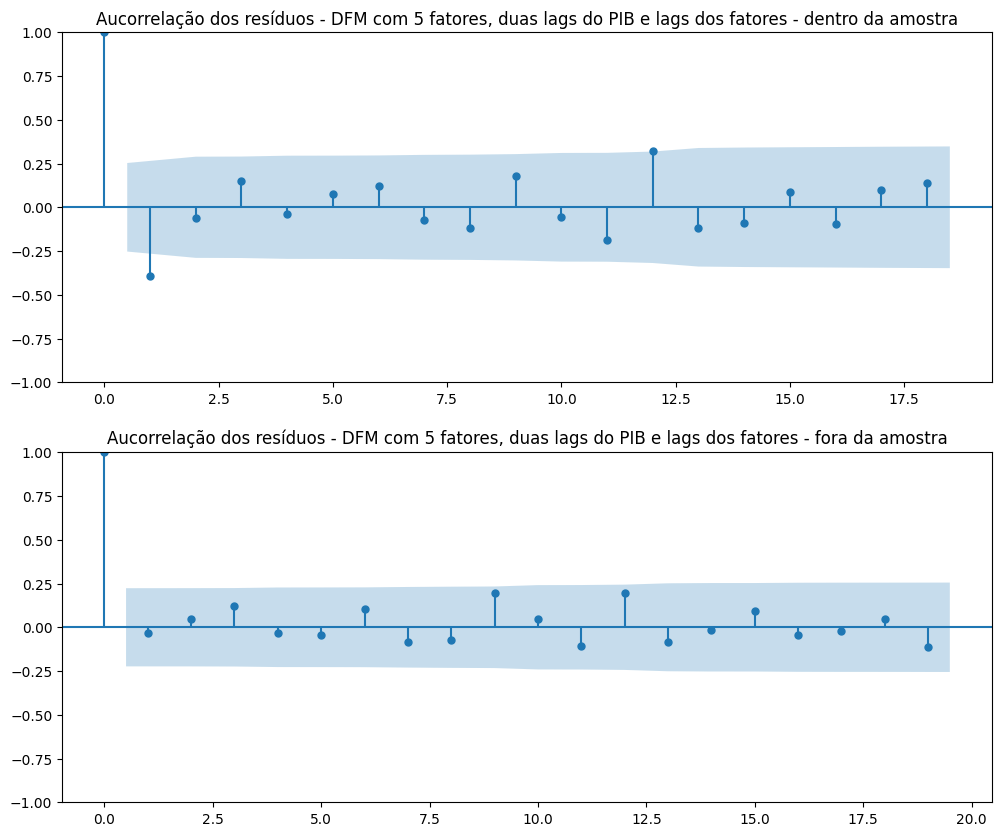

In [697]:
# Plotando a função de autocorrelação

autocorr_plots(dfm.resid, dfm_5fac.resid,
               'Autocorrelação dos resíduos - DFM com 5 fatores, duas lags do PIB e lags dos fatores - dentro da amostra',
               'Autocorrelação dos resíduos - DFM com 5 fatores, duas lags do PIB e lags dos fatores - fora da amostra')

c:\Users\HENRI\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


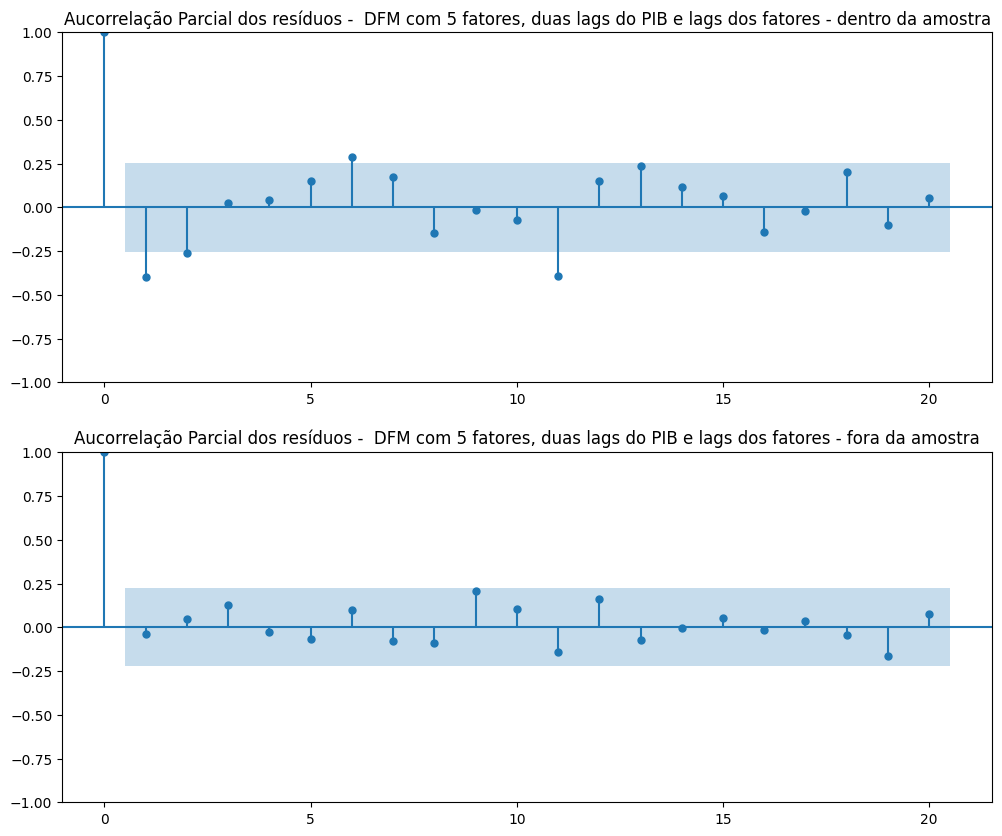

In [698]:
# Plotando a função de autocorrelação

part_autocorr_plots(dfm.resid, dfm_5fac.resid,
               'Aucorrelação Parcial dos resíduos -  DFM com 5 fatores, duas lags do PIB e lags dos fatores - dentro da amostra',
               'Aucorrelação Parcial dos resíduos -  DFM com 5 fatores, duas lags do PIB e lags dos fatores - fora da amostra')

In [699]:
# Teste de Breusch-Godfray para autocorrelação dos erros - IN-SAMPLE

bg_result = acorr_breusch_godfrey(dfm, nlags = 12)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm.resid, lags = 12)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.0124

   lb_stat  lb_pvalue
1   9.6285     0.0019
2   9.8754     0.0072
3  11.3232     0.0101
4  11.4183     0.0222
5  11.7810     0.0379
6  12.8277     0.0459
7  13.2195     0.0669
8  14.2644     0.0751


In [700]:
# Teste de Breusch-Godfray para autocorrelação dos erros - OUT-OF-SAMPLE 

bg_result = acorr_breusch_godfrey(dfm_5fac, nlags = 12)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm_5fac.resid, lags = 12)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.6134

   lb_stat  lb_pvalue
1   0.0987     0.7534
2   0.3001     0.8607
3   1.4794     0.6870
4   1.5640     0.8152
5   1.7457     0.8831
6   2.6569     0.8505
7   3.3136     0.8546
8   3.7769     0.8767


## Heteroscedasticidade

In [701]:
# Teste de heteroscedasticidade - IN-SAMPLE

het_breuschpagan(dfm.resid.loc['2003Q3':'2017Q4',], X_train.loc['2003Q3':'2017Q4',])

(38.75690065739257,
 0.3903580856569223,
 1.0600355173495015,
 0.45746851977422115)

In [702]:
# Teste de heteroscedasticidade - OUT-OF-SAMPLE

het_breuschpagan(dfm_5fac.resid.loc['2003Q3':'2022Q2',], new_data.loc['2003Q3':'2022Q2',])

(48.03795574142541,
 0.12749957200060547,
 1.6298690614379265,
 0.06917078189649281)

<AxesSubplot: xlabel='date', ylabel='resid'>

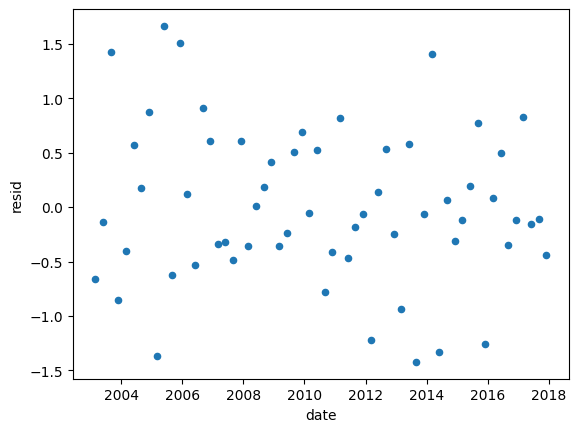

In [703]:
# Modelo com dados apenas dentro da amostra

resids_plot = pd.DataFrame({'date':dfm.resid.index, 'resid':dfm.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

<AxesSubplot: xlabel='date', ylabel='resid'>

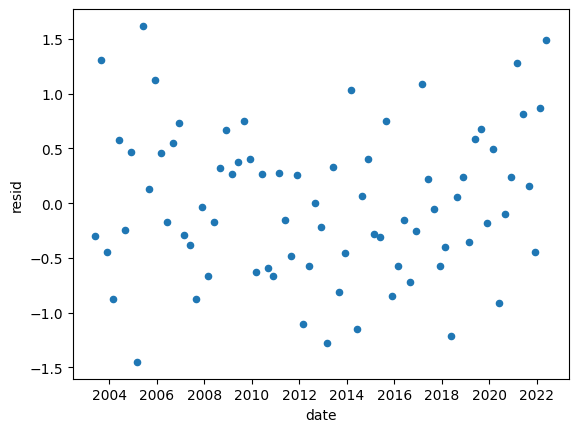

In [704]:
# Out-of-sample

resids_plot = pd.DataFrame({'date':dfm_5fac.resid.index, 'resid':dfm_5fac.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

In [705]:
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F4_6,F5_1,F5_2,F5_3,F5_4,gdp_1,gdp_2,gdp_3,gdp_4,e_1
2002-03-01,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411,0.437357,3.542712,-1.410008,1.441429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-01,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521,0.555046,2.055331,-1.683349,2.263962,...,NaN,-0.599411,NaN,NaN,NaN,0.388552,NaN,NaN,NaN,NaN
2002-09-01,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402,1.708108,2.452098,0.985706,2.723189,...,NaN,-0.766521,-0.599411,NaN,NaN,4.320709,0.388552,NaN,NaN,NaN
2002-12-01,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546,1.241341,2.347363,-0.177495,3.033051,...,NaN,-1.604402,-0.766521,-0.599411,NaN,3.543887,4.320709,0.388552,NaN,NaN
2003-03-01,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151,0.577081,4.299099,-1.396467,0.792031,...,NaN,-3.549546,-1.604402,-0.766521,-0.599411,-0.217573,3.543887,4.320709,0.388552,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580,-0.136194,-1.399026,1.282804,-0.357813,...,0.531945,0.472862,-2.798624,1.553859,2.008675,0.551384,-0.548361,1.805440,10.420355,0.689880
2021-12-01,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121,-0.989648,-1.303261,1.347845,1.466352,...,-2.892059,-0.206580,0.472862,-2.798624,1.553859,2.578462,0.551384,-0.548361,1.805440,-0.377894
2022-03-01,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385,1.439377,-0.281474,0.233960,-3.768976,...,-5.300418,1.034121,-0.206580,0.472862,-2.798624,-0.432211,2.578462,0.551384,-0.548361,-0.237969
2022-06-01,1.786737,-0.366600,-0.601419,0.377088,-1.336048,-1.747521,-0.829394,0.277045,2.288487,-4.953368,...,-5.972295,-1.059385,1.034121,-0.206580,0.472862,-0.262737,-0.432211,2.578462,0.551384,0.952619
